# Modelling weekly close price with SARIMAX

## Imports and data

In [34]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#aggregating data from days to weeks:

sp500_d = pd.read_csv(r'C:\Users\swift5\WEC2023\spx_d.csv', sep=',')
m2_weekly = pd.read_csv(r'C:\Users\swift5\WEC2023\WM2NS.csv', sep=',')

def aggregate_daily_to_weekly(daily_df, weekly_df):
    # Convert the date columns to datetime objects
    daily_df['Date_c'] = pd.to_datetime(daily_df['Data'],  format='%d/%m/%Y')
    weekly_df['Date_c'] = pd.to_datetime(weekly_df['DATE'],  format='%d/%m/%Y')
    
    # Create a new dataframe to store the aggregated values
    agg_df = pd.DataFrame()
    
    # Loop through the dates in the weekly dataframe
    last_date = 0
    for date in weekly_df['Date_c']:

        # Select the rows in the daily dataframe that are before the current date
        if last_date==0:
            mask = daily_df['Date_c'] <= date
        else:
            mask = (last_date < daily_df['Date_c']) & (daily_df['Date_c'] <= date)
          
        last_date = date
        selected_rows = daily_df.loc[mask]
        
        # Aggregate the selected rows using the mean() function 
        agg_row = selected_rows.iloc[:,1:6].mean()
        
        # Add the current date from the weekly dataframe to the aggregated row
        agg_row['Data'] = date
        
        agg_row = pd.DataFrame(agg_row).T
        # Append the aggregated row to the new dataframe
        agg_df = pd.concat([agg_df, agg_row])
        
        
    return agg_df

aggregate_daily_to_weekly(sp500_d, m2_weekly).to_csv('spx_w_aggr.csv')

Load datasets

In [56]:
weekly_M2_SP = pd.read_csv(r'C:\Users\swift5\WEC2023\M2_SP500_week_aggr.csv')
weekly_M2_SP['Date'] =  pd.to_datetime(weekly_M2_SP['Date'],  format='%d/%m/%Y')
weekly_M2_SP.set_index('Date', inplace=True)
weekly_M2_SP
weekly_M2_SP.index = pd.date_range(start=weekly_M2_SP.index.min(), end=weekly_M2_SP.index.max(), freq='W')
print(weekly_M2_SP.index.freq)

<Week: weekday=6>


# Seasonality

<Axes: >

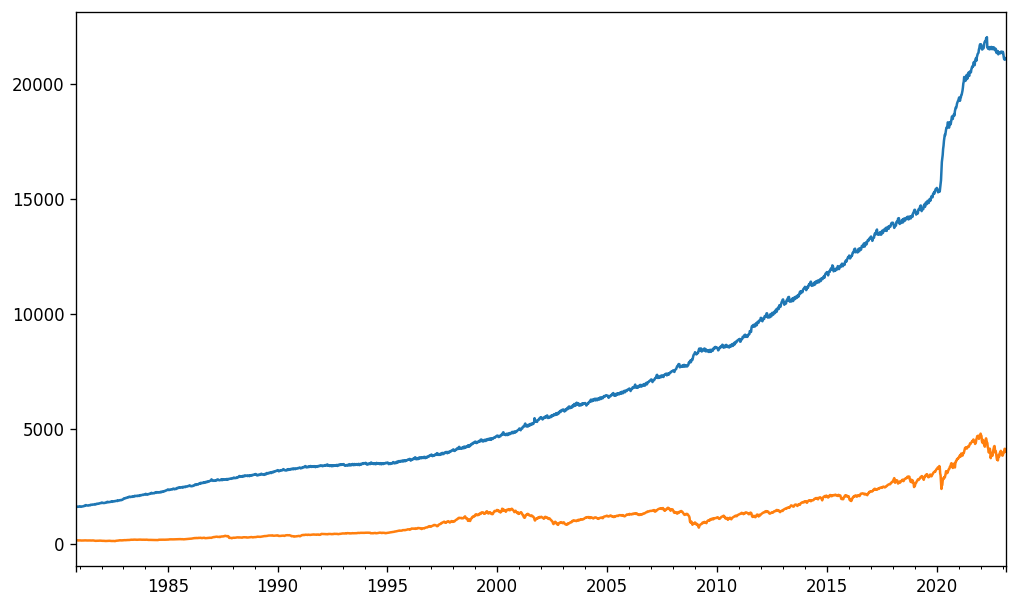

In [57]:
weekly_M2_SP['WM2NS'].plot()
weekly_M2_SP['Close'].plot()

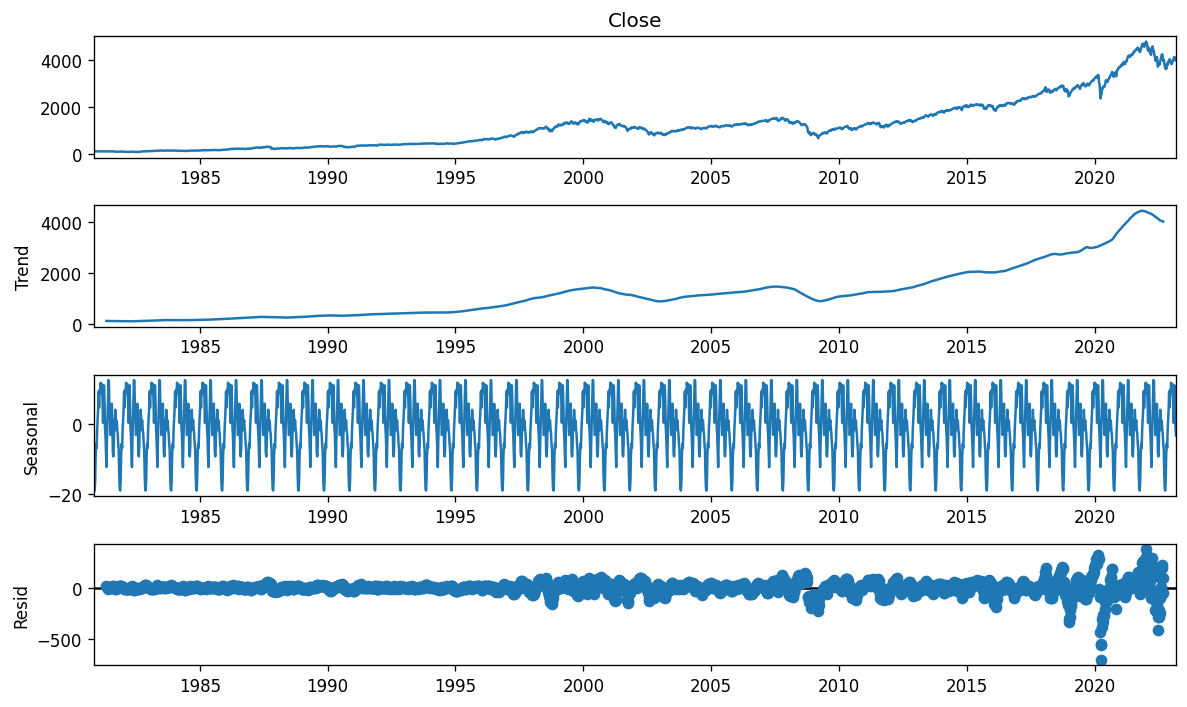

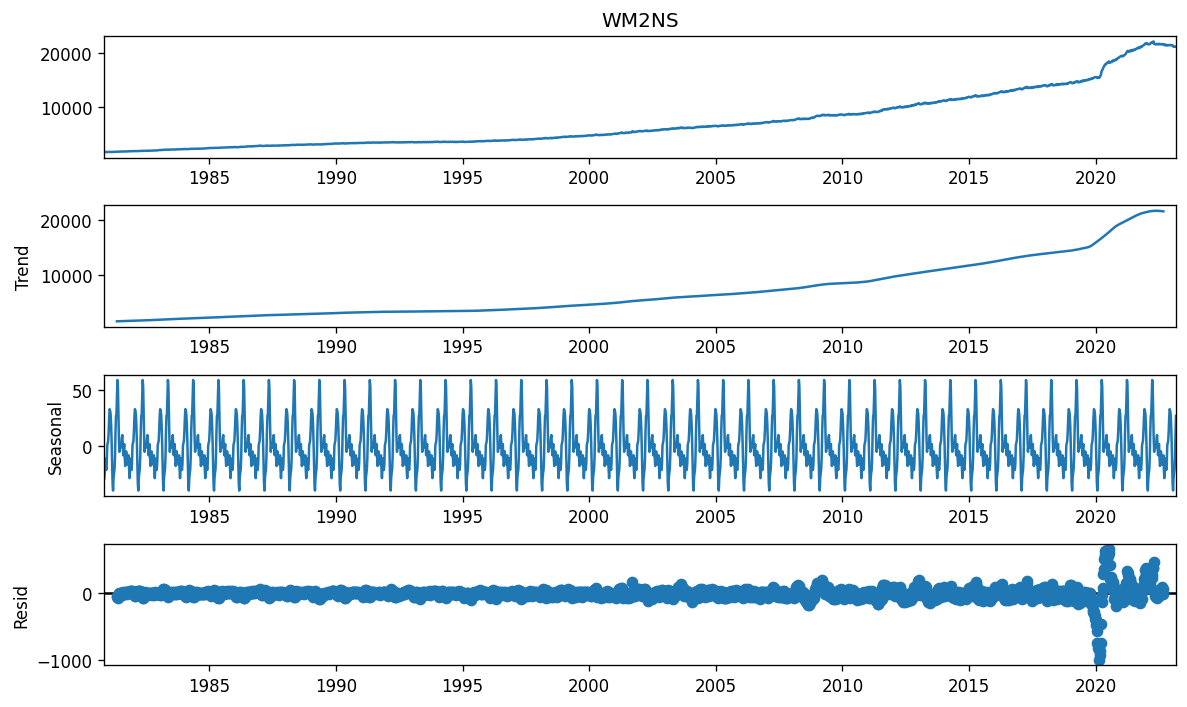

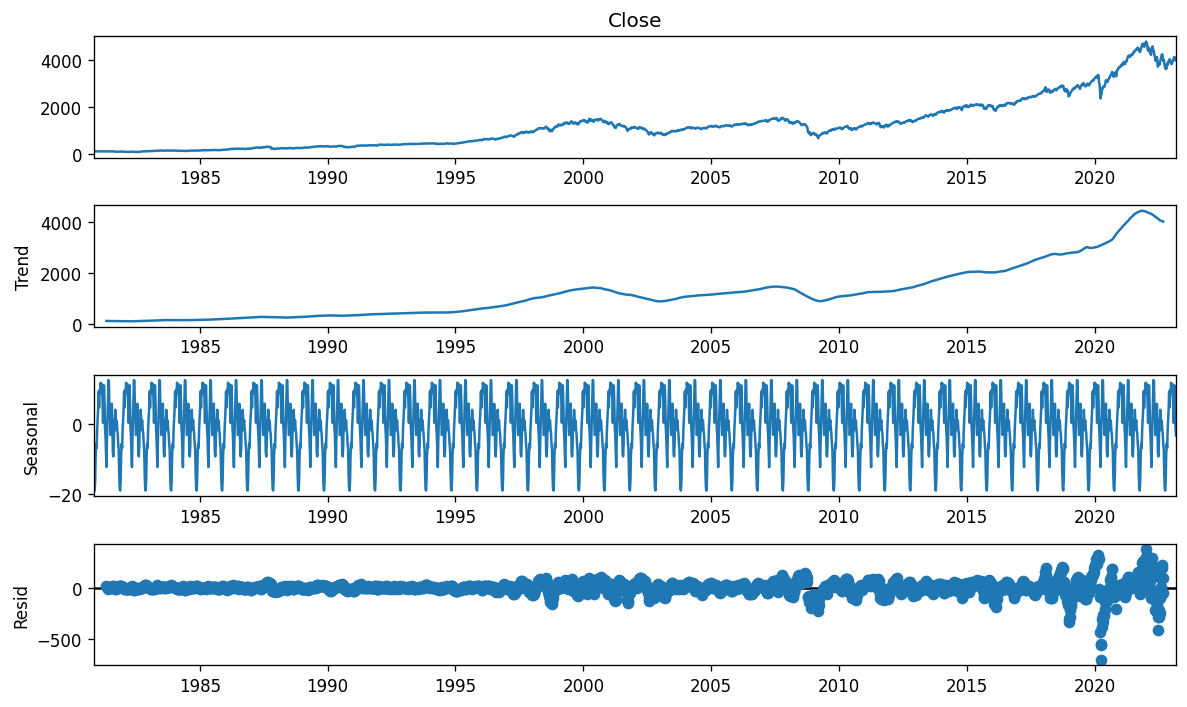

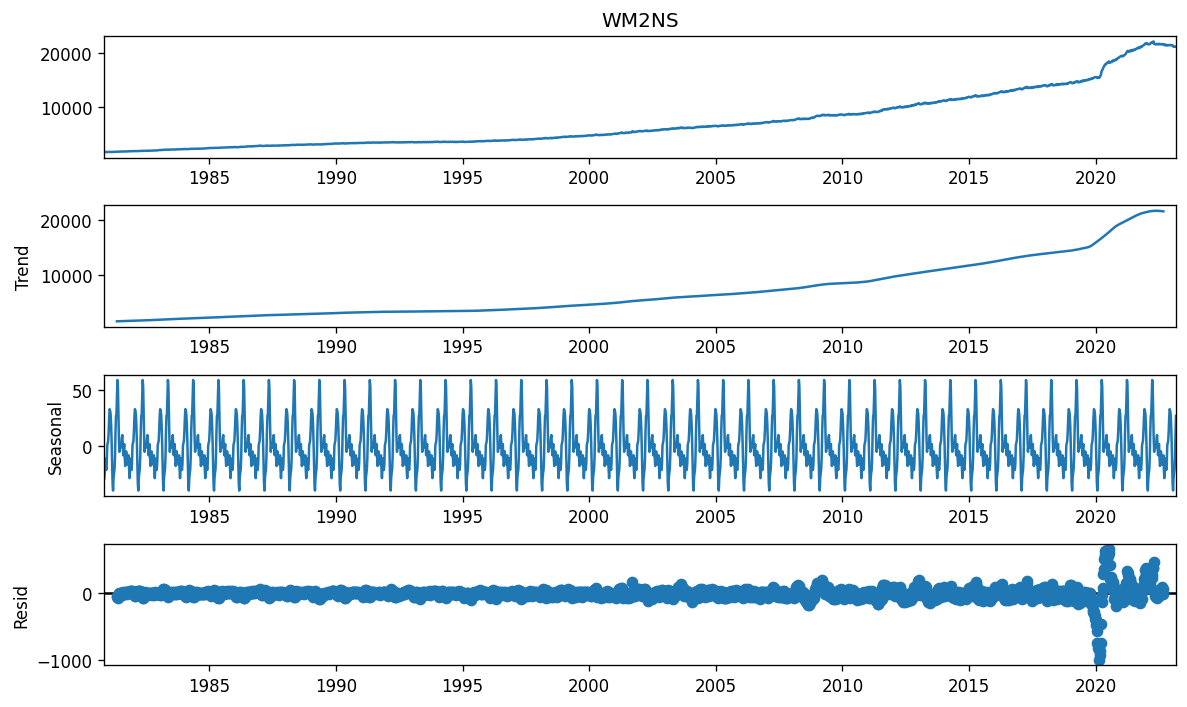

In [58]:
display(sm.tsa.seasonal_decompose(weekly_M2_SP['Close'],model='additive').plot())
display(sm.tsa.seasonal_decompose(weekly_M2_SP['WM2NS'],model='additive').plot())
# sm.tsa.seasonal_decompose(weekly_M2_SP['Close'],model='additive').seasonal.plot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

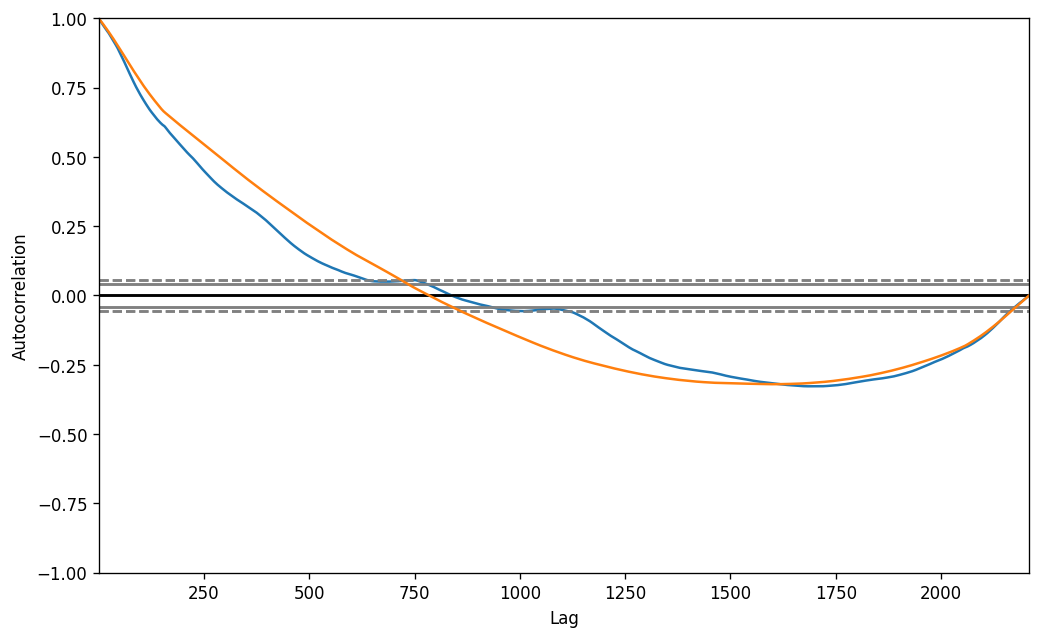

In [59]:
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Draw Plot
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})
autocorrelation_plot(weekly_M2_SP['Close'].tolist())
autocorrelation_plot(weekly_M2_SP['WM2NS'].tolist())

# Stationarity and test for no White Noise

## Imports

In [60]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [61]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

## Close series

In [62]:
adf_test(weekly_M2_SP['Close'])
kpss_test(weekly_M2_SP['Close'])

adf_test(weekly_M2_SP['WM2NS'])
kpss_test(weekly_M2_SP['WM2NS'])

Results of Dickey-Fuller Test:
Test Statistic                    1.185811
p-value                           0.995886
#Lags Used                       26.000000
Number of Observations Used    2182.000000
Critical Value (1%)              -3.433350
Critical Value (5%)              -2.862866
Critical Value (10%)             -2.567476
dtype: float64
Results of KPSS Test:
Test Statistic            5.845841
p-value                   0.010000
Lags Used                29.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Dickey-Fuller Test:


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic                    2.573581
p-value                           0.999070
#Lags Used                       27.000000
Number of Observations Used    2181.000000
Critical Value (1%)              -3.433352
Critical Value (5%)              -2.862866
Critical Value (10%)             -2.567476
dtype: float64
Results of KPSS Test:
Test Statistic            6.363367
p-value                   0.010000
Lags Used                29.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Basic series non-stationary

### Log and diff

<Axes: >

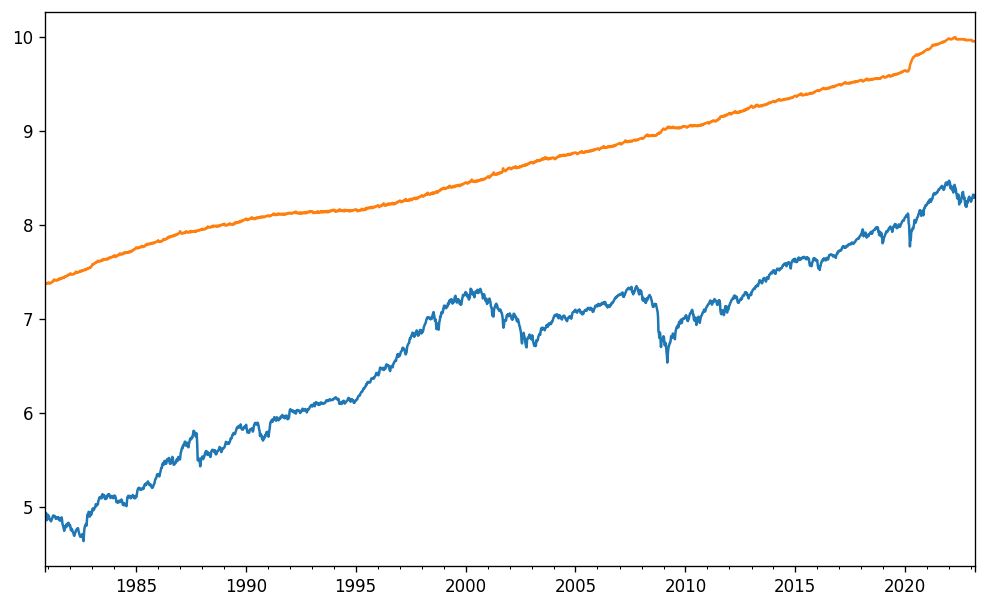

In [63]:
weekly_M2_SP['lnClose'] = np.log(weekly_M2_SP['Close'])
weekly_M2_SP.dropna(inplace=True)
weekly_M2_SP['lnWM2NS'] = np.log(weekly_M2_SP['WM2NS'])
weekly_M2_SP.dropna(inplace=True)
weekly_M2_SP['lnClose'].plot()
weekly_M2_SP['lnWM2NS'].plot()

In [64]:
adf_test(weekly_M2_SP['lnClose'])
kpss_test(weekly_M2_SP['lnClose'])
adf_test(weekly_M2_SP['lnWM2NS'])
kpss_test(weekly_M2_SP['lnWM2NS'])

Results of Dickey-Fuller Test:
Test Statistic                   -0.990404
p-value                           0.756748
#Lags Used                        1.000000
Number of Observations Used    2207.000000
Critical Value (1%)              -3.433316
Critical Value (5%)              -2.862850
Critical Value (10%)             -2.567468
dtype: float64
Results of KPSS Test:
Test Statistic            6.807126
p-value                   0.010000
Lags Used                29.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Dickey-Fuller Test:


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Test Statistic                    0.127122
p-value                           0.967865
#Lags Used                       27.000000
Number of Observations Used    2181.000000
Critical Value (1%)              -3.433352
Critical Value (5%)              -2.862866
Critical Value (10%)             -2.567476
dtype: float64
Results of KPSS Test:
Test Statistic            7.333331
p-value                   0.010000
Lags Used                29.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


Both tests show non-stationarity

<Axes: >

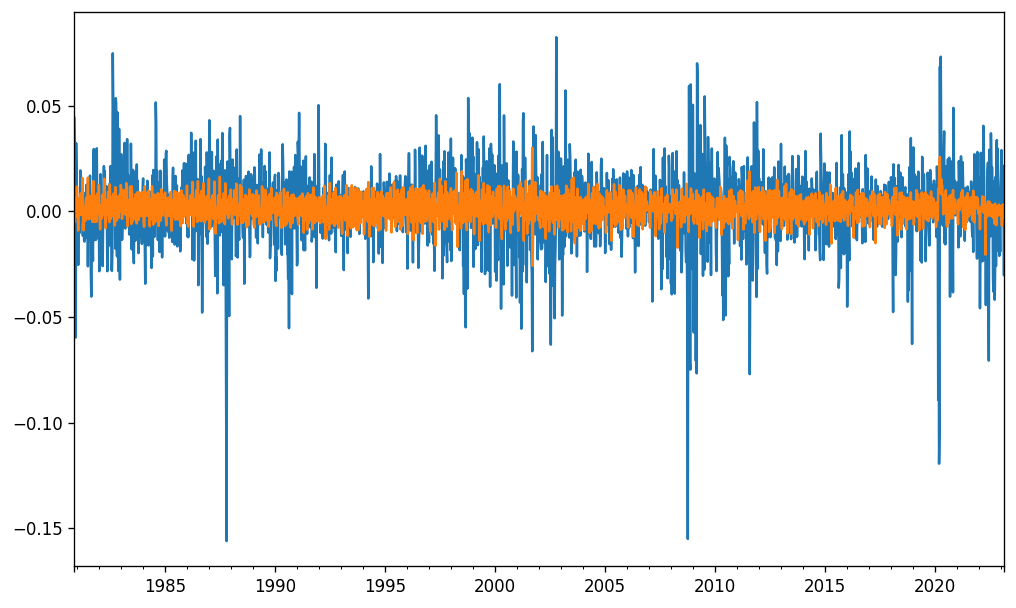

In [65]:
weekly_M2_SP['lnClose_diff1'] = weekly_M2_SP['lnClose']- weekly_M2_SP['lnClose'].shift(1)
weekly_M2_SP.dropna(inplace=True)
weekly_M2_SP['lnWM2NS_diff1'] = weekly_M2_SP['lnWM2NS']- weekly_M2_SP['lnWM2NS'].shift(1)
weekly_M2_SP.dropna(inplace=True)
weekly_M2_SP['lnClose_diff1'].plot()
weekly_M2_SP['lnWM2NS_diff1'].plot()

In [66]:
adf_test(weekly_M2_SP['lnClose_diff1'])
kpss_test(weekly_M2_SP['lnClose_diff1'])
adf_test(weekly_M2_SP['lnWM2NS_diff1'])
kpss_test(weekly_M2_SP['lnWM2NS_diff1'])

Results of Dickey-Fuller Test:
Test Statistic                  -38.849130
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2206.000000
Critical Value (1%)              -3.433318
Critical Value (5%)              -2.862851
Critical Value (10%)             -2.567468
dtype: float64
Results of KPSS Test:
Test Statistic           0.092721
p-value                  0.100000
Lags Used                2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.044307e+00
p-value                        5.739360e-10
#Lags Used                     2.700000e+01
Number of Observations Used    2.179000e+03
Critical Value (1%)           -3.433355e+00
Critical Value (5%)           -2.862867e+00
Critical Value (10%)          -2.567477e+00
dtype: float64
Results of KPSS Test:
Te

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Both tests show stationarity

### Diff once

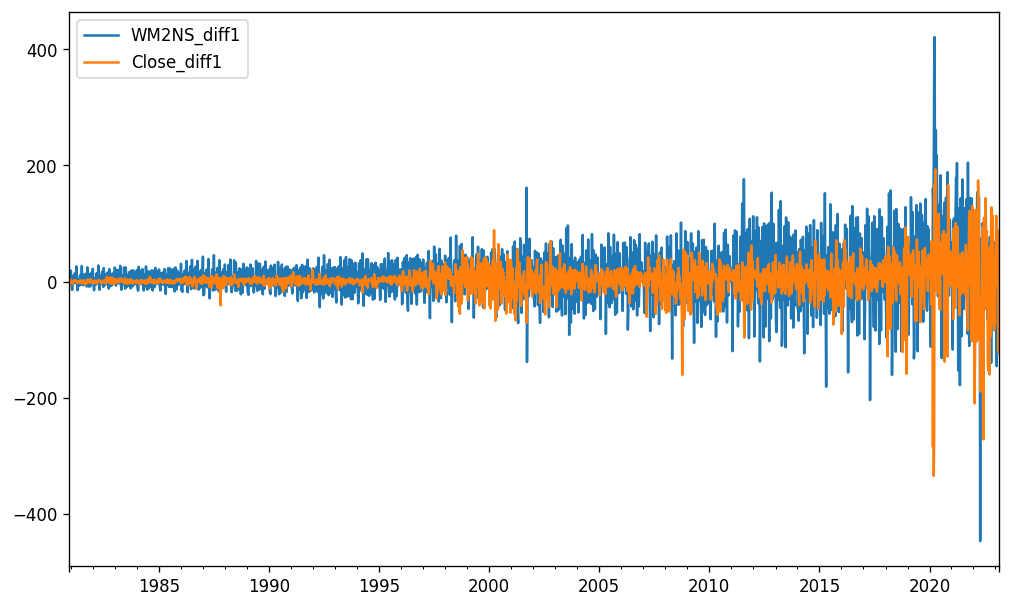

In [67]:
weekly_M2_SP['Close_diff1'] = weekly_M2_SP['Close']- weekly_M2_SP['Close'].shift(1)
weekly_M2_SP.dropna(inplace=True)
weekly_M2_SP['WM2NS_diff1'] = weekly_M2_SP['WM2NS']- weekly_M2_SP['WM2NS'].shift(1)
weekly_M2_SP.dropna(inplace=True)
weekly_M2_SP['WM2NS_diff1'].plot()
weekly_M2_SP['Close_diff1'].plot()
plt.legend(['WM2NS_diff1','Close_diff1'])


In [68]:
adf_test(weekly_M2_SP['Close_diff1'])
kpss_test(weekly_M2_SP['Close_diff1'])
adf_test(weekly_M2_SP['WM2NS_diff1'])
kpss_test(weekly_M2_SP['WM2NS_diff1'])

Results of Dickey-Fuller Test:
Test Statistic                -8.536519e+00
p-value                        1.004568e-13
#Lags Used                     2.500000e+01
Number of Observations Used    2.179000e+03
Critical Value (1%)           -3.433355e+00
Critical Value (5%)           -2.862867e+00
Critical Value (10%)          -2.567477e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.399437
p-value                   0.077398
Lags Used                10.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -5.502368
p-value                           0.000002
#Lags Used                       26.000000
Number of Observations Used    2178.000000
Critical Value (1%)              -3.433356
Critical Value (5%)              -2.862868
Critical Value (10%)             -2.567477
dtype: float64
Results of KPSS T

c:\Users\swift5\anaconda3\envs\ml-env\Lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


### White noise test Ljung-Box

In [69]:
sm.stats.acorr_ljungbox(weekly_M2_SP['lnClose_diff1'], lags=range(1,12), return_df=True)

,lb_stat,lb_pvalue
1,78.102728,9.781878e-19
2,78.415798,9.380497e-18
3,78.543714,6.300463e-17
4,82.507733,5.123184e-17
5,82.839138,2.135565e-16
6,83.815154,5.808239e-16
7,84.054488,2.046565e-15
8,84.167495,7.059307e-15
9,84.702582,1.870528e-14
10,85.712031,3.777193e-14


Base series non-stationary

# SARIMAX

In [70]:
#splitting the data to train and test sets (test for 12 weeks)
train = weekly_M2_SP.iloc[:-12]
test = weekly_M2_SP.iloc[-12:]

## Choosing p and q

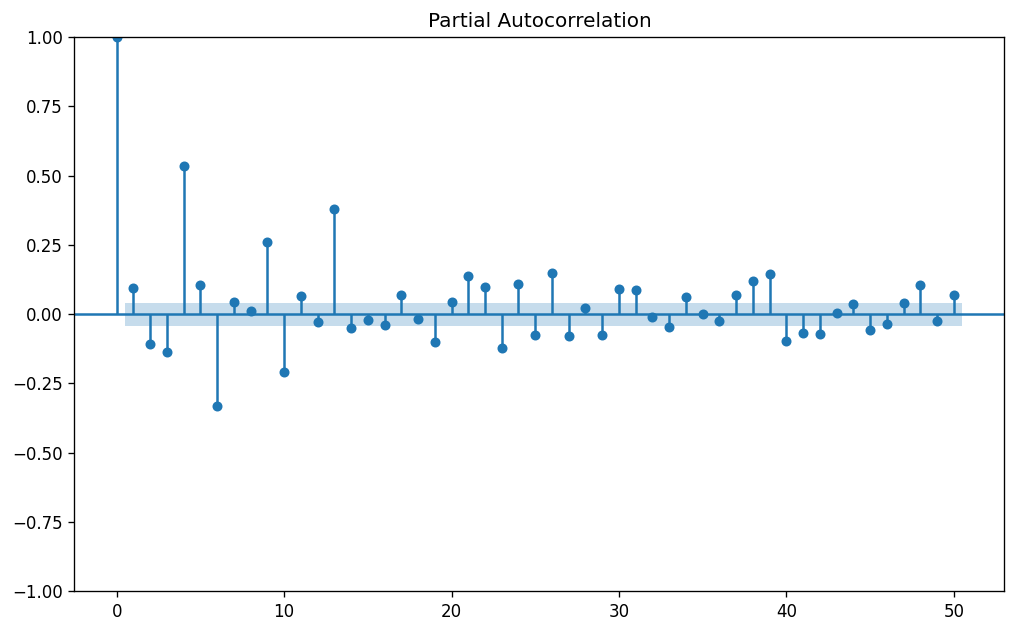

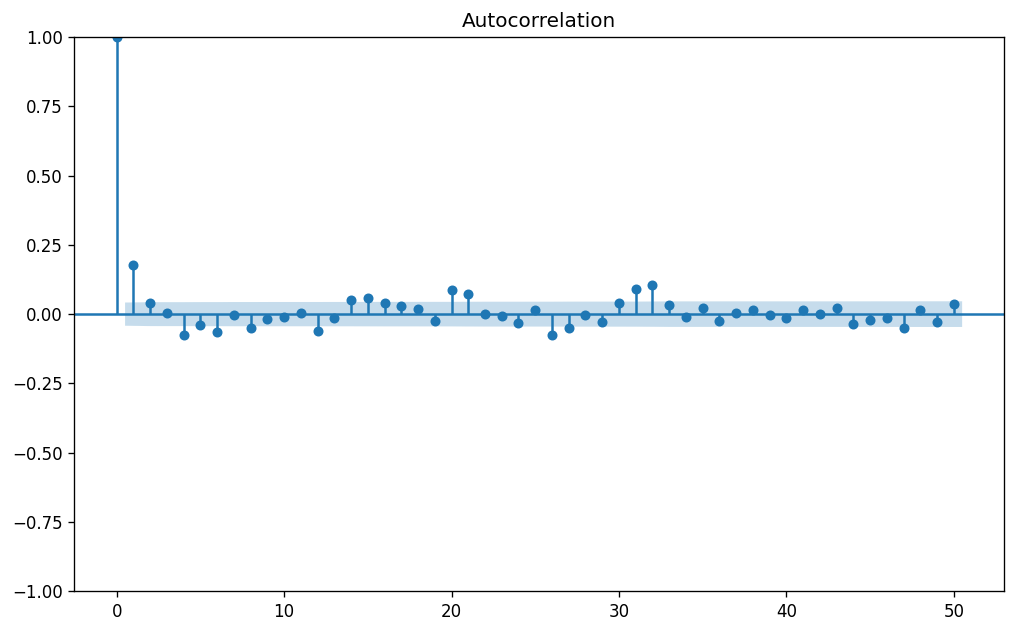

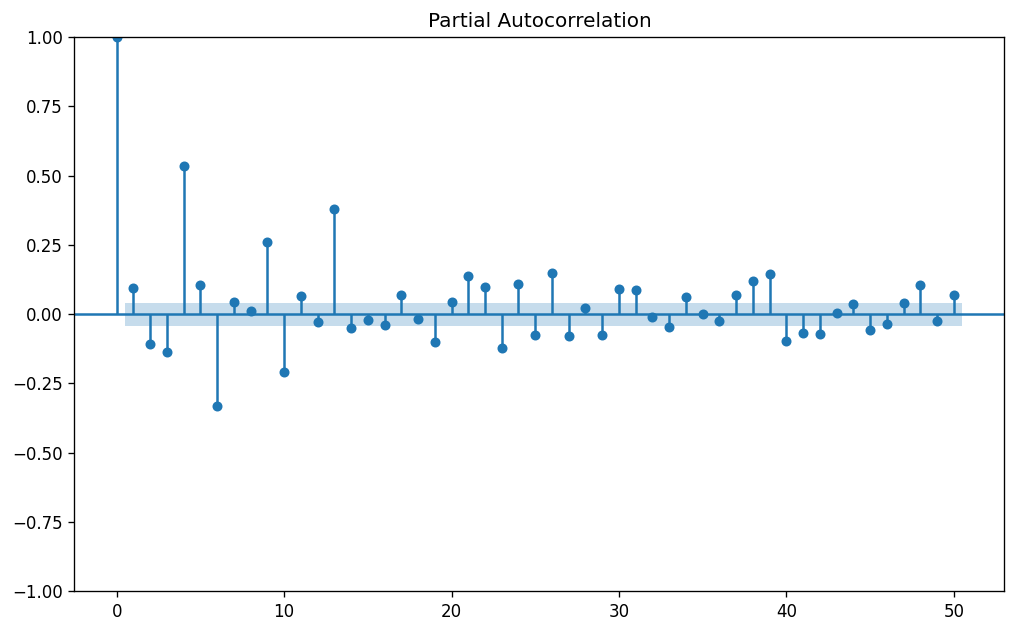

In [71]:
sm.graphics.tsa.plot_acf(train["Close_diff1"].values.squeeze(), lags=50)
sm.graphics.tsa.plot_pacf(train["WM2NS_diff1"].values.squeeze(), lags=50, method="ywm")

Box-Jenkins p=2 q=3

## Model choice

In [72]:
import itertools

In [73]:

p = range(0,3)
q = range(0,2)
# for already differentiated series
d = [0]
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], ) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1)
SARIMAX: (0, 0, 1) x (1, 0, 0)
SARIMAX: (1, 0, 0) x (1, 0, 1)
SARIMAX: (1, 0, 0) x (2, 0, 0)


In [74]:
for param in pdq:
 #   for param_seasonal in seasonal_pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(endog=train['Close_diff1'],
                                        exog =train['WM2NS_diff1'],\
                                        trend='n',\
                                        order=param)
                                        #seasonal_order=param_seasonal)

        results = mod.fit()

        print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    except:
        continue

SARIMAX(0, 0, 0)x(2, 0, 1)12 - AIC:21261.81817308835
SARIMAX(0, 0, 1)x(2, 0, 1)12 - AIC:21194.71742421608
SARIMAX(1, 0, 0)x(2, 0, 1)12 - AIC:21191.216978546177
SARIMAX(1, 0, 1)x(2, 0, 1)12 - AIC:21192.965856151455
SARIMAX(2, 0, 0)x(2, 0, 1)12 - AIC:21192.94450626227
SARIMAX(2, 0, 1)x(2, 0, 1)12 - AIC:21185.30232004726


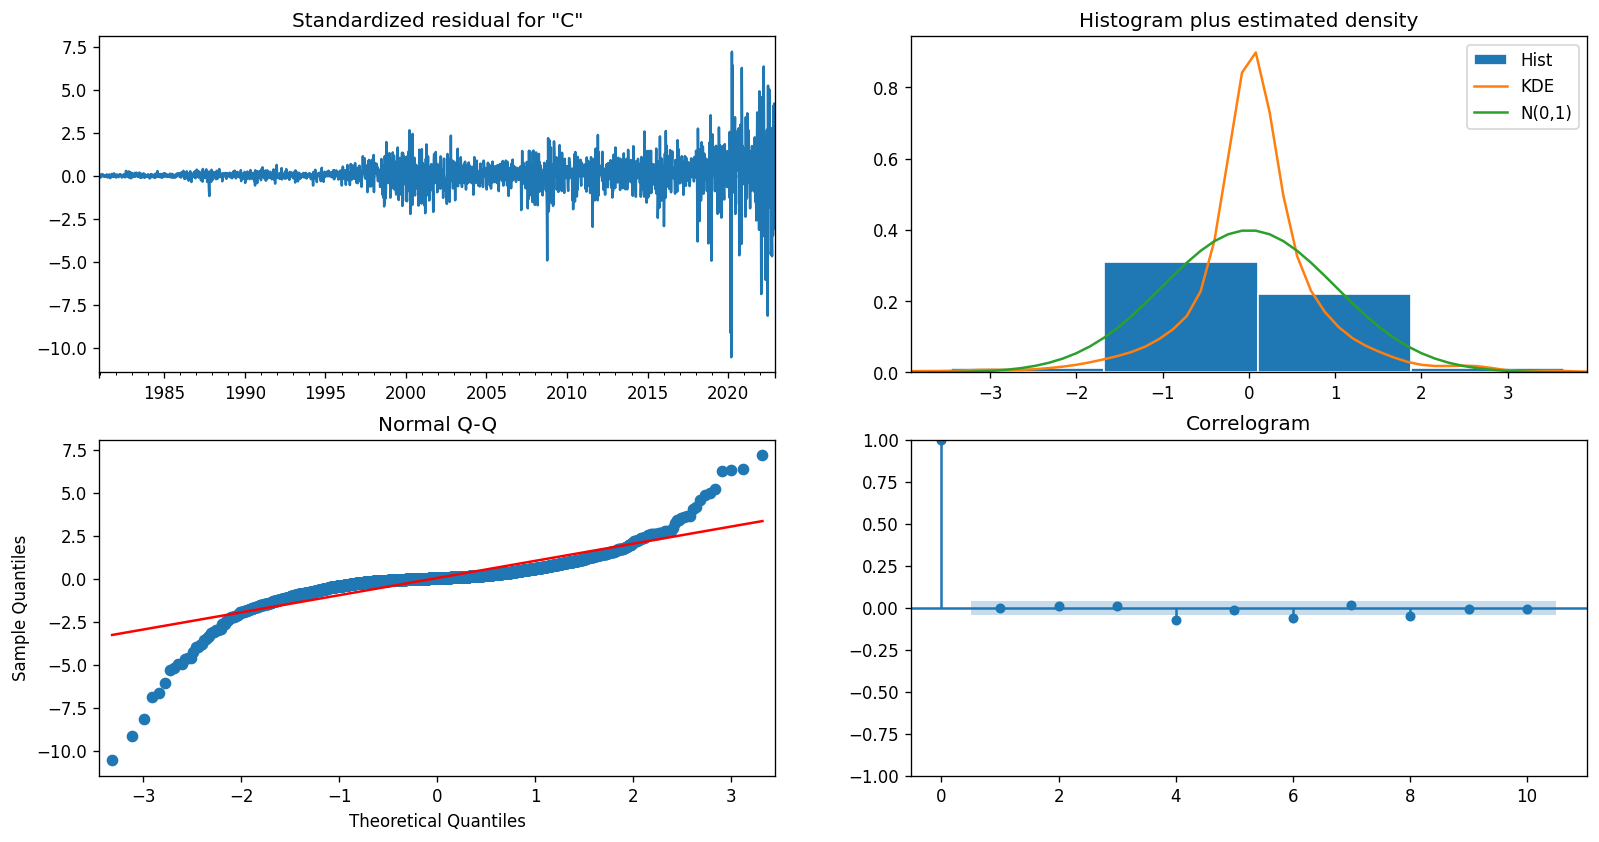

In [75]:
#lowest AIC: SARIMAX(2, 0, 1)x(2, 0, 0, 12)12 - AIC:21180.27985812391

mod = sm.tsa.statespace.SARIMAX(endog=train['Close_diff1'],
                                exog =train['WM2NS_diff1'],\
                                order=(2, 0, 1),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

results.plot_diagnostics(figsize=(16, 8))
plt.show()

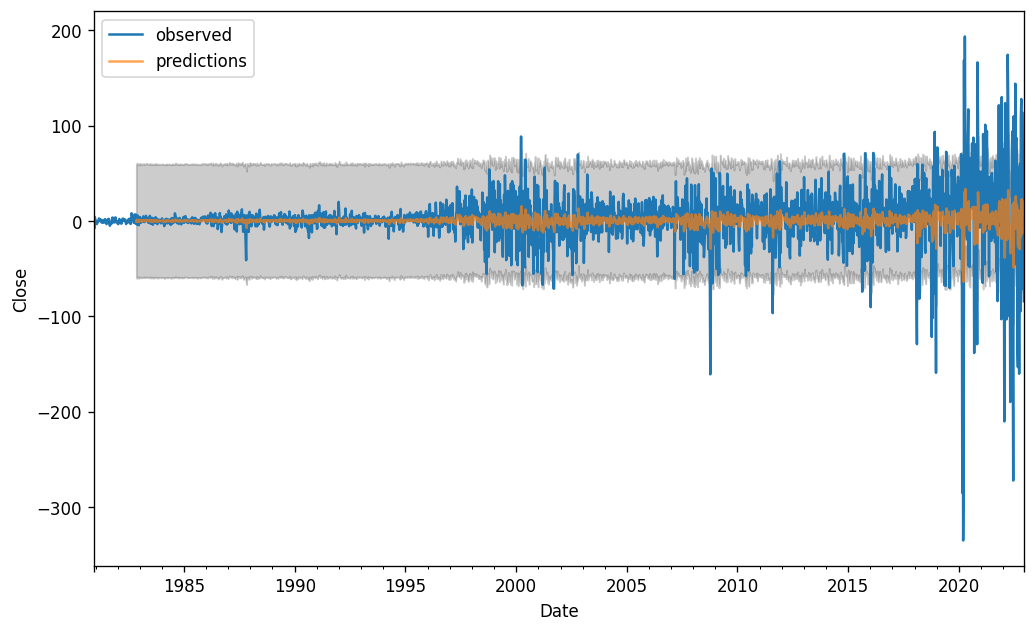

In [76]:
start_forecast = 100
pred = results.get_prediction(start=start_forecast, dynamic=False)
pred_ci = pred.conf_int()

ax = train['Close_diff1'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='predictions', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Close')
plt.legend()

plt.show()

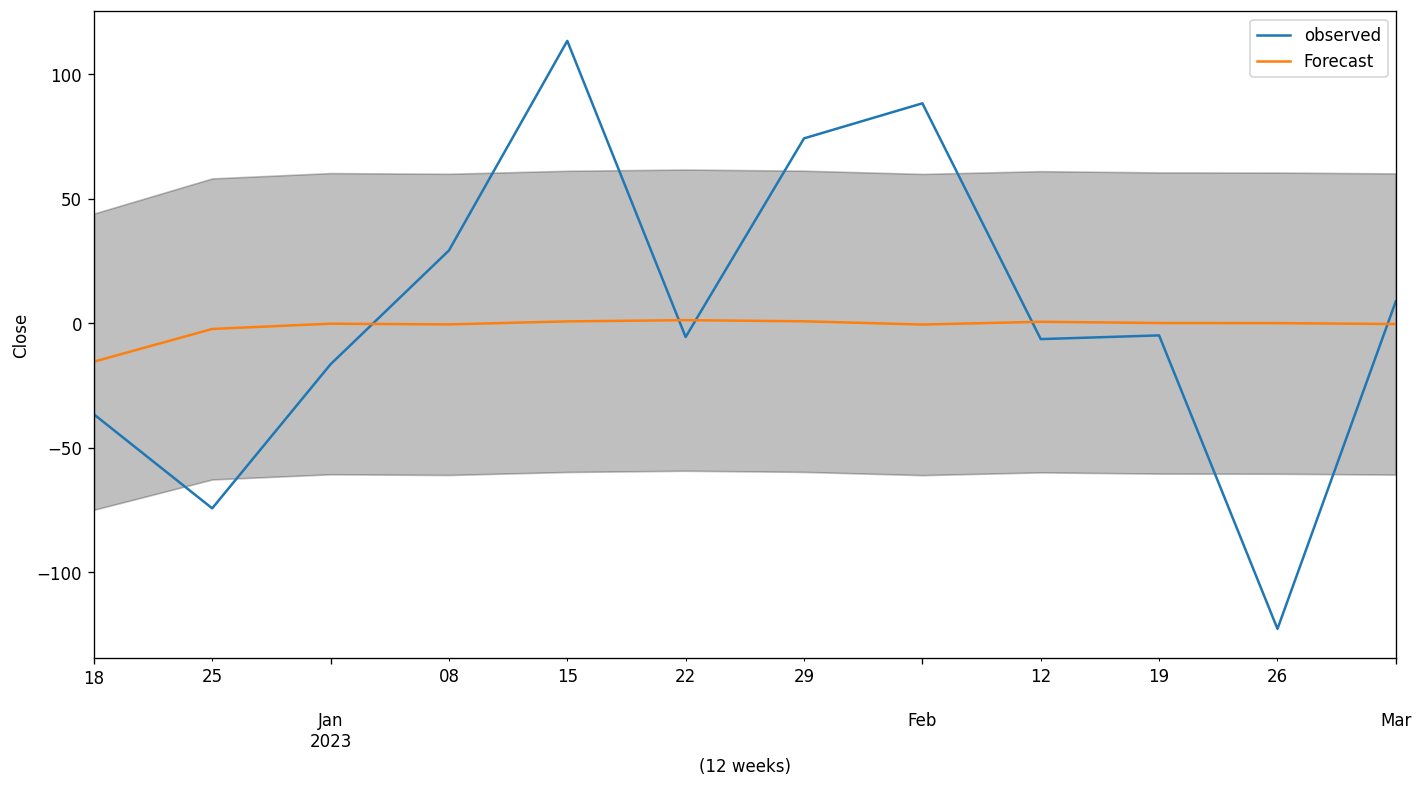

In [77]:
#%% Forecast 1y
import os

pred_uc = results.get_forecast(steps=12, exog=test['WM2NS_diff1']) #12 weeks
pred_ci = pred_uc.conf_int()
ax = test['Close_diff1'].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('(12 weeks)')
ax.set_ylabel('Close')
plt.legend()
plt.show()
plt.close()


In [78]:
#!pip install scikit-learn

from sklearn.metrics import mean_squared_error, mean_absolute_error

y_true = test['Close']

y_pred = [train['Close'][-1] + pred_uc.predicted_mean[0]]

for diff in pred_uc.predicted_mean[1:]:
    pred_value = y_pred[-1] + diff
    y_pred.append(pred_value)

def MAPE(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true)) * 100

print("MAPE: ", MAPE(y_true, y_pred))
print("MSE: ", mean_squared_error(y_true, y_pred))
print("MAE: ",mean_absolute_error(y_true, y_pred))

for table in results.summary().tables:
    print('#################################################')
    print(table.as_latex_tabular())

MAPE:  2.334956413617888
MSE:  12118.564304452133
MAE:  93.70747766705442
#################################################
\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}   &   Close\_diff1   & \textbf{  No. Observations:  } &    2193     \\
\textbf{Model:}           & SARIMAX(2, 0, 1) & \textbf{  Log Likelihood     } & -10583.978  \\
\textbf{Date:}            & Sat, 22 Apr 2023 & \textbf{  AIC                } & 21177.957   \\
\textbf{Time:}            &     22:43:51     & \textbf{  BIC                } & 21206.417   \\
\textbf{Sample:}          &    12-07-1980    & \textbf{  HQIC               } & 21188.359   \\
\textbf{}                 &   - 12-11-2022   & \textbf{                     } &             \\
\textbf{Covariance Type:} &       opg        & \textbf{                     } &             \\
\bottomrule
\end{tabular}
%\caption{SARIMAX Results}
\end{center}
#################################################
\begin{center}
\begin{tabular}{lcccccc}
\toprule
